# Capstone Application: A method of detecting AI generated text

**Overview**: In this project, our goal is to detect AI generated text by using supervised machine learning algorithms and compare the performance of the classifiers we encountered in this section, namely Logistic Regression, Decision Trees, Naive Bayes and Support Vector Machines. We will utilize a dataset collected from students and chatgpt generated text.  



### Problem 1: Understanding the Data

The dataset is from kaggle and contains a dataset named the "Detect- AI Generated VS Student Generated Text". We are to use the text column to classify whether the text was generated by AI or not. 


### Problem 2: Read in the Data

Use pandas to read in the dataset `LLMdata.csv` and assign to a meaningful variable name.

In [1]:
# import python libraries
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import nltk

from nltk import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.compose import make_column_transformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
from datetime import datetime

In [2]:
# read the dataset into dataframe
df = pd.read_csv('data/LLMdata.csv', sep = ',').drop(columns='Unnamed: 0')

In [3]:
df.head()

,Text,Label
0,y r u always l8 to the meetings?,student
1,The project team embraced a user-centric desig...,ai
2,"i dont like dealing with risks, it's too stres...",student
3,"i dont worry about reliability, it's good enough",student
4,"i dont care about human-centered design, just ...",student


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
1 - Text (string)

Output variable (desired target):
2 - Label - The source of input text (binary: 'ai','student')
```



In [4]:
# data cleanup
# check all the missing strings in the dataset
dfunkn = (df.isnull()).sum()
dfu = pd.DataFrame(dfunkn, columns=['count']).reset_index()
dfu = dfu.query('count > 0').sort_values(by='count', ascending=False)
print('Before data cleanup, missing value count =', dfu['count'].sum())
dfu

Before data cleanup, missing value count = 1


,index,count
1,Label,1


In [5]:
# clean up the dataset by dropping missing strings
dfX = df.copy()
dfX = dfX.dropna()
dfuncnt = (dfX.isnull()).sum()
print('After data cleanup, missing value count =', dfuncnt.sum())

After data cleanup, missing value count = 0


### Problem 4: Understanding the Task

After examining the description and data, our goal now is to clearly state the *Business Objective* of the task.  State the objective below.

Our business goal is to compare different classifiers, find the best classification model and predict if the text is generated by AI.

### Problem 5: Engineering Features

Now that you understand our business objective, we will build a basic model to get started. Before we can do this, we must work to process the text data. Prepare the features and target column for modeling with appropriate encoding and transformations.

In [6]:
# display dataset info
print(dfX.info())
dfX.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 1102 entries, 0 to 1102
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    1102 non-null   object
 1   Label   1102 non-null   object
dtypes: object(2)
memory usage: 25.8+ KB
None


,Text,Label
count,1102,1102
unique,664,2
top,"i dont talk about limitations, it makes me loo...",ai
freq,31,552


In [7]:
# seperate dataset into features and the target variabl
import warnings
warnings.simplefilter('ignore', FutureWarning)

X = dfX.drop(columns=['Label'])
y = dfX['Label'].map({'student':0, 'ai':1})


Text(0.5, 1.0, 'Histogram of target variable distribution')

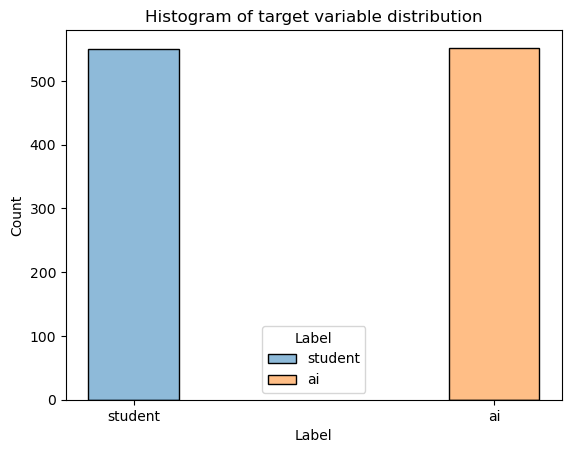

In [8]:
# show the target variable distribution
ax = sns.histplot(df, x='Label', hue='Label', shrink=0.25)
plt.title('Histogram of target variable distribution')

In [9]:
# build a function to process text data 
def stemmer(text):
    lstem = []
    tokens = word_tokenize(text)
    for token in tokens:
        tok1 = WordNetLemmatizer().lemmatize(token)
        lstem.append(PorterStemmer().stem(tok1))
    return ' '.join(lstem)
dfX['tokens'] = dfX['Text'].apply(stemmer)
dfX.head()

,Text,Label,tokens
0,y r u always l8 to the meetings?,student,y r u alway l8 to the meet ?
1,The project team embraced a user-centric desig...,ai,the project team embrac a user-centr design ap...
2,"i dont like dealing with risks, it's too stres...",student,"i dont like deal with risk , it 's too stress"
3,"i dont worry about reliability, it's good enough",student,"i dont worri about reliabl , it 's good enough"
4,"i dont care about human-centered design, just ...",student,"i dont care about human-cent design , just giv..."


### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [10]:
bestparam = []
cvectscore = []
tfidfscore = []
X = dfX[['tokens']]
y = dfX['Label'].map({'student':0, 'ai':1})
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size=0.33)

print('The training set shape =', X_train.shape)
print('The testing set shape =', X_test.shape)

The training set shape = (738, 1)
The testing set shape = (364, 1)


### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [11]:
##### build a dummy classifier as our baseline
from sklearn.dummy import DummyClassifier

baseline = DummyClassifier(strategy='most_frequent')
baseline.fit(X_train, y_train)
train_score = baseline.score(X_train, y_train)
print('Baseline dummy classifier model')
print('train accuracy =', train_score)
test_score = baseline.score(X_test, y_test)
print('test accuracy =', test_score)
f1_score = metrics.f1_score(y_test, baseline.predict(X_test))
print('F1 score =', f1_score)
print('The baseline dummy classifier model just randomly guess so its train accuracy is 50%.')

Baseline dummy classifier model
train accuracy = 0.5067750677506775
test accuracy = 0.4835164835164835
F1 score = 0.0
The baseline dummy classifier model just randomly guess so its train accuracy is 50%.


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [12]:
%%time
# LogosticRegression model
cvect_pipe1 = Pipeline([
    ('cvect', CountVectorizer()),
    ('lgr', LogisticRegression())])
print('LogisticRegression')
time1 = datetime.now() 
cvect_pipe1.fit(X_train['tokens'], y_train)
duration = (datetime.now() - time1)
print('train time =', duration.total_seconds(), 'secs')
test_acc = cvect_pipe1.score(X_test['tokens'], y_test)
f1_score = metrics.f1_score(y_test, cvect_pipe1.predict(X_test['tokens']))
print('f1 score', f1_score)
print('test acc', test_acc)
cvectscore.append(test_acc)

LogisticRegression
train time = 0.063167 secs
f1 score 0.9868073878627969
test acc 0.9862637362637363
CPU times: total: 31.2 ms
Wall time: 72.1 ms


      feature      coef
612       the  1.981387
477   project  1.158903
303        in  1.074378
602      team  1.060826
28        and  0.803115
582     studi  0.772117
27    analysi  0.746845
513  research  0.714126
254       for  0.713161
37        are  0.646105


Text(0.5, 1.0, 'Table of top 10 features')

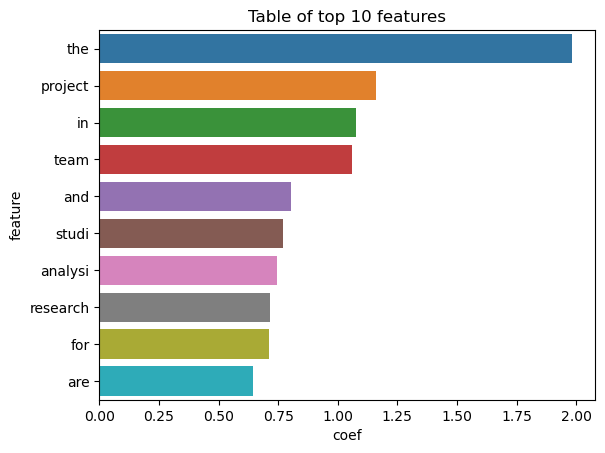

In [13]:
# LogosticRegression basic model coefficients
dflgr = pd.DataFrame({'feature':cvect_pipe1.named_steps['cvect'].get_feature_names_out(), 
                      'coef':cvect_pipe1.named_steps['lgr'].coef_[0]})
dflgr = dflgr.sort_values(by='coef', ascending=False)
#dflgr
# data visualization
top10 = dflgr.head(10)
print(top10)
sns.barplot(top10, y='feature', x='coef')
plt.title('Table of top 10 features')

In [14]:
%%time
# DecisionTree model
cvect_pipe2 = Pipeline([
    ('cvect', CountVectorizer()),
    ('dtr', DecisionTreeClassifier())])
print('DecisionTreeClassifier')
time1 = datetime.now() 
cvect_pipe2.fit(X_train['tokens'], y_train)
duration = (datetime.now() - time1)
print('train time =', duration.total_seconds(), 'secs')
test_acc = cvect_pipe2.score(X_test['tokens'], y_test)
f1_score = metrics.f1_score(y_test, cvect_pipe2.predict(X_test['tokens']))
print('f1 score', f1_score)
print('test acc', test_acc)
cvectscore.append(test_acc)

DecisionTreeClassifier
train time = 0.045888 secs
f1 score 0.9866666666666667
test acc 0.9862637362637363
CPU times: total: 15.6 ms
Wall time: 57.1 ms


In [15]:
%%time
# MultinomialNB model
cvect_pipe3 = Pipeline([
    ('cvect', CountVectorizer()),
    ('mnb', MultinomialNB())])
print('MultinomialNB')
time1 = datetime.now() 
cvect_pipe3.fit(X_train['tokens'], y_train)
duration = (datetime.now() - time1)
print('train time =', duration.total_seconds(), 'secs')
test_acc = cvect_pipe3.score(X_test['tokens'], y_test)
f1_score = metrics.f1_score(y_test, cvect_pipe3.predict(X_test['tokens']))
print('f1 score', f1_score)
print('test acc', test_acc)
cvectscore.append(test_acc)

MultinomialNB
train time = 0.027021 secs
f1 score 0.9894736842105264
test acc 0.989010989010989
CPU times: total: 15.6 ms
Wall time: 43.2 ms


In [16]:
%%time
# SupportVectorMachine model
cvect_pipe4 = Pipeline([
    ('cvect', CountVectorizer()),
    ('svc', SVC())])
print('SupportVectorMachine')
time1 = datetime.now() 
cvect_pipe4.fit(X_train['tokens'], y_train)
duration = (datetime.now() - time1)
print('train time =', duration.total_seconds(), 'secs')
test_acc = cvect_pipe4.score(X_test['tokens'], y_test)
f1_score = metrics.f1_score(y_test, cvect_pipe4.predict(X_test['tokens']))
print('f1 score', f1_score)
print('test acc', test_acc)
cvectscore.append(test_acc)

SupportVectorMachine
train time = 0.042599 secs
f1 score 0.9920424403183024
test acc 0.9917582417582418
CPU times: total: 15.6 ms
Wall time: 67.8 ms


### Problem 9: Score the Model

What is the accuracy of your model?

The SupportVectorMachine has the highest test accuracy 99%.

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our Decision Tree, NaiveBayes and SVM models. Present your findings in a `DataFrame`.



In [17]:
pd.set_option('display.max_colwidth', 100)
models = ['LogisticRegression','DecisionTree','NaiveBayes','SVC']
dfmc = pd.DataFrame({
    'Model': models,
    'Test Accuracy': cvectscore,
})
dfmc

,Model,Test Accuracy
0,LogisticRegression,0.986264
1,DecisionTree,0.986264
2,NaiveBayes,0.989011
3,SVC,0.991758


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep or remove the stop words? 
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the type of kernels in SVC or the maximum depth of a Decision Tree.  
- Adjust your performance metrics

In [18]:
# Initialize the table 
bestparam = []
cvectscore = []
f1scores = []

In [19]:
%%time
# LogosticRegression model
params1 = {'cvect__max_features': [500, 750, 1000],
          'cvect__stop_words': ['english', None],
          'lgr__C': [0.01, 0.1, 1, 10, 100]}
cvect_pipe1 = Pipeline([
    ('cvect', CountVectorizer()),
    ('lgr', LogisticRegression())])
print('LogisticRegression')
grid_cvlgr = GridSearchCV(cvect_pipe1, param_grid=params1, scoring='f1', cv=2, verbose=1)
time1 = datetime.now() 
grid_cvlgr.fit(X_train['tokens'], y_train)
duration = (datetime.now() - time1)
test_acc = grid_cvlgr.best_estimator_.score(X_test['tokens'], y_test)
f1_score = metrics.f1_score(y_test, grid_cvlgr.best_estimator_.predict(X_test['tokens']))
print(grid_cvlgr.best_params_)
print('f1 score', f1_score)
print('test acc', test_acc)
print('time spent', grid_cvlgr.cv_results_['mean_fit_time'].mean())
bestparam.append(grid_cvlgr.best_params_)
cvectscore.append(test_acc)
f1scores.append(f1_score)

LogisticRegression
Fitting 2 folds for each of 30 candidates, totalling 60 fits
{'cvect__max_features': 750, 'cvect__stop_words': None, 'lgr__C': 10}
f1 score 0.9894179894179894
test acc 0.989010989010989
time spent 0.010783151785532633
CPU times: total: 734 ms
Wall time: 972 ms


In [20]:
%%time
# DecisionTree model
params2 = {'cvect__max_features': [500, 750, 1000],
          'cvect__stop_words': ['english', None],
          'dtr__criterion': ['gini', 'entropy'],
          'dtr__max_depth': [5, 6, 7, 8]}
cvect_pipe2 = Pipeline([
    ('cvect', CountVectorizer()),
    ('dtr', DecisionTreeClassifier())])
print('DecisionTreeClassifier')
grid_cvdtr = GridSearchCV(cvect_pipe2, param_grid=params2, scoring='f1', cv=2, verbose=1)
time1 = datetime.now() 
grid_cvdtr.fit(X_train['tokens'], y_train)
duration = (datetime.now() - time1)
print('train time =', duration.total_seconds(), 'secs')
test_acc = grid_cvdtr.best_estimator_.score(X_test['tokens'], y_test)
f1_score = metrics.f1_score(y_test, grid_cvdtr.best_estimator_.predict(X_test['tokens']))
print(grid_cvdtr.best_params_)
print('f1 score', f1_score)
print('test acc', test_acc)
print('time spent', grid_cvdtr.cv_results_['mean_fit_time'].mean())
bestparam.append(grid_cvdtr.best_params_)
cvectscore.append(test_acc)
f1scores.append(f1_score)

DecisionTreeClassifier
Fitting 2 folds for each of 48 candidates, totalling 96 fits
train time = 1.244916 secs
{'cvect__max_features': 500, 'cvect__stop_words': None, 'dtr__criterion': 'entropy', 'dtr__max_depth': 7}
f1 score 0.9866666666666667
test acc 0.9862637362637363
time spent 0.007131536801656087
CPU times: total: 984 ms
Wall time: 1.26 s


In [21]:
%%time
# MultinomialNB model
params3 = {'cvect__max_features': [500, 750, 1000],
          'cvect__stop_words': ['english', None],
          'mnb__alpha': [0.1, 1.0, 10]}
cvect_pipe3 = Pipeline([
    ('cvect', CountVectorizer()),
    ('mnb', MultinomialNB())])
print('MultinomialNB')
grid_cvmnb = GridSearchCV(cvect_pipe3, param_grid=params3, scoring='f1', cv=2, verbose=1)
time1 = datetime.now() 
grid_cvmnb.fit(X_train['tokens'], y_train)
duration = (datetime.now() - time1)
test_acc = grid_cvmnb.best_estimator_.score(X_test['tokens'], y_test)
f1_score = metrics.f1_score(y_test, grid_cvmnb.best_estimator_.predict(X_test['tokens']))
print(grid_cvmnb.best_params_)
print('f1 score', f1_score)
print('test acc', test_acc)
print('time spent', grid_cvmnb.cv_results_['mean_fit_time'].mean())
bestparam.append(grid_cvmnb.best_params_)
cvectscore.append(test_acc)
f1scores.append(f1_score)

MultinomialNB
Fitting 2 folds for each of 18 candidates, totalling 36 fits
{'cvect__max_features': 500, 'cvect__stop_words': None, 'mnb__alpha': 1.0}
f1 score 0.9894736842105264
test acc 0.989010989010989
time spent 0.006071097320980496
CPU times: total: 234 ms
Wall time: 439 ms


In [22]:
%%time
# SupportVectorMachine model
params4 = {'cvect__max_features': [500, 750, 1000],
          'cvect__stop_words': ['english', None],
          'svc__kernel': ['rbf', 'poly'],
          'svc__gamma': ['auto', 'scale']}
cvect_pipe4 = Pipeline([
    ('cvect', CountVectorizer()),
    ('svc', SVC())])
print('SupportVectorMachine')
grid_cvsvc = GridSearchCV(cvect_pipe4, param_grid=params4, scoring='f1', cv=2, verbose=1)
time1 = datetime.now() 
grid_cvsvc.fit(X_train['tokens'], y_train)
duration = (datetime.now() - time1)
print('train time =', duration.total_seconds(), 'secs')
test_acc = grid_cvsvc.best_estimator_.score(X_test['tokens'], y_test)
f1_score = metrics.f1_score(y_test, grid_cvsvc.best_estimator_.predict(X_test['tokens']))
print(grid_cvsvc.best_params_)
print('f1 score', f1_score)
print('test acc', test_acc)
print('time spent', grid_cvsvc.cv_results_['mean_fit_time'].mean())
bestparam.append(grid_cvsvc.best_params_)
cvectscore.append(test_acc)
f1scores.append(f1_score)

SupportVectorMachine
Fitting 2 folds for each of 24 candidates, totalling 48 fits
train time = 1.350026 secs
{'cvect__max_features': 750, 'cvect__stop_words': None, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
f1 score 0.9920424403183024
test acc 0.9917582417582418
time spent 0.01388700803120931
CPU times: total: 969 ms
Wall time: 1.38 s


In [23]:
# Display the result table after feature engineering and hyperparameters tuning
pd.set_option('display.max_colwidth', 150)
dfmb = pd.DataFrame({
    'Model': models,
    'Best Paramaters': bestparam,
    'Test Accuracy': cvectscore,
    'F1 score': f1scores
})
dfmb

,Model,Best Paramaters,Test Accuracy,F1 score
0,LogisticRegression,"{'cvect__max_features': 750, 'cvect__stop_words': None, 'lgr__C': 10}",0.989011,0.989418
1,DecisionTree,"{'cvect__max_features': 500, 'cvect__stop_words': None, 'dtr__criterion': 'entropy', 'dtr__max_depth': 7}",0.986264,0.986667
2,NaiveBayes,"{'cvect__max_features': 500, 'cvect__stop_words': None, 'mnb__alpha': 1.0}",0.989011,0.989474
3,SVC,"{'cvect__max_features': 750, 'cvect__stop_words': None, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}",0.991758,0.992042


Text(0.5, 1.0, 'Comparison of Model accuracy (Higher the better)')

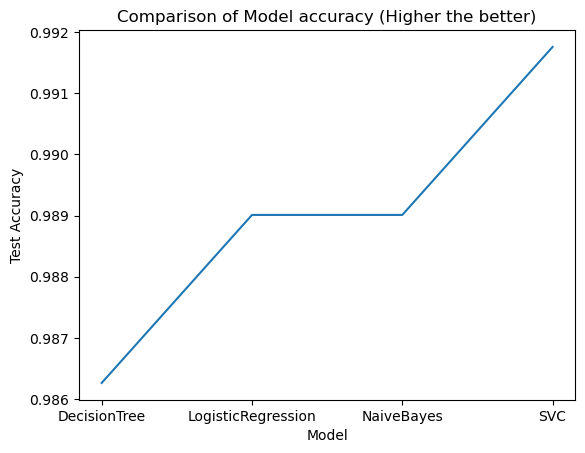

In [24]:
# Display the plot after feature engineering and hyperparameters tuning
sns.lineplot(dfmb.sort_values(by='Test Accuracy'), x='Model', y='Test Accuracy')
plt.title('Comparison of Model accuracy (Higher the better)')

Text(0.5, 1.0, 'SVC(kernel="rbf") classifier decision boundary plot')

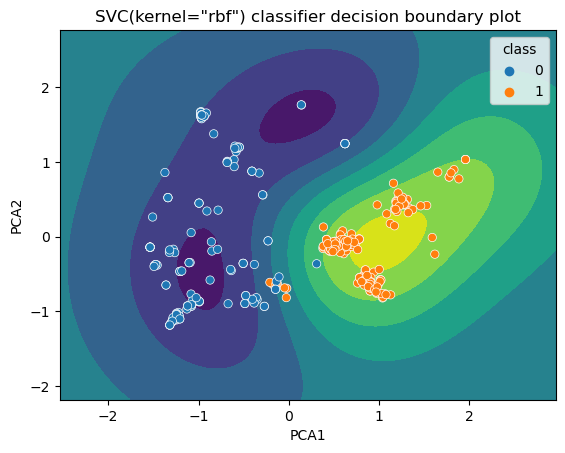

In [25]:
# Data visualization
from sklearn.decomposition import PCA
from sklearn.inspection import DecisionBoundaryDisplay

cvr = CountVectorizer().fit(X_test['tokens'])
dfcvr = pd.DataFrame(cvr.transform(X_test['tokens']).todense(), columns=cvr.get_feature_names_out())
#print(dfcvr)
pca = PCA(n_components=2)
dd = pca.fit_transform(dfcvr)
#print(dd)
dfpca = pd.DataFrame({'PCA1':dd[:,0], 'PCA2':dd[:,1]})
mod_svc = SVC(kernel='rbf', gamma='scale').fit(dfpca, y_test)

DecisionBoundaryDisplay.from_estimator(
    estimator=mod_svc, X=dfpca)
dfy = pd.DataFrame({'class':y_test})
sns.scatterplot(dfpca, x=dd[:,0], y=dd[:,1], hue=dfy['class'])
plt.title('SVC(kernel="rbf") classifier decision boundary plot')

SupportVectorMachine
f1 score 0.9920424403183024


Text(0.5, 1.0, 'SVC(kernel="rbf") classifier confusion matrix plot')

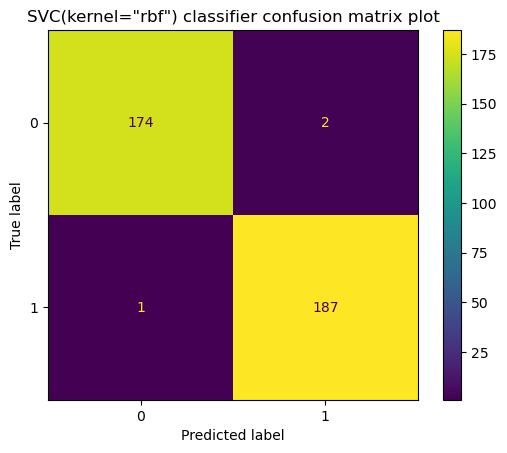

In [26]:
# Confusion matrix plot
preds = grid_cvsvc.best_estimator_.predict(X_test['tokens'])
print('SupportVectorMachine')
print('f1 score', metrics.f1_score(y_test, preds))
cmtx = confusion_matrix(y_test, preds) 
disp = ConfusionMatrixDisplay(cmtx)
disp.plot()
plt.title('SVC(kernel="rbf") classifier confusion matrix plot')

### Summary

We are able to detect AI generated text by using supervised machine learning technique. This is a binary classification problem and the dataset is balanced. I built and compared four classifier models: LogisticRegression, DecisionTree, NaiveBayes and SupportVectorMachine. After feature engineering and hyperparameters tuning, SupportVerctorMachine is the best model (F1 score = 99.2%) with nonlinear kernel 'rbf'. 

I would like to deploy this model to my web server and continue to optimize model performance by collecting more AI generated text. I will also optimize it with other machine learning technique such as Ensemble model and Neural Network. I hope this can be useful and turned into a good business tool.